# 0. Data Importing from kaggle

In [1]:
import os
from tqdm.notebook import tqdm
for dirname, _, filenames in tqdm(os.walk('/kaggle/input')):
    for filename in filenames:
        os.path.join(dirname, filename)
#         print(os.path.join(dirname, filename))

0it [00:00, ?it/s]

# Limiting GPU usage

In [2]:
# limit memory to prevent data leak
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    del logical_gpus,gpus
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


2 Physical GPUs, 2 Logical GPUs


# 1. Importing modules

In [3]:
import numpy as np
import pandas as pd
import json
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
train_files = glob("../input/quickdraw-doodle-recognition/train_simplified/*.csv")
testing = True
# calculating data size per category
rows = 200000

if testing:
    rows = 10000 # testing

rows = rows - (rows % 340)
cat_size = rows // 340
print(cat_size)
gc.collect()

29


56

# 2. Data Importing and Image Preprocessing 
1. Data Importing and Removing unwanted columns
2. converting data in text json to an image 
3. normalizing the image size
4. normalizing the image pixels


In [4]:
from PIL import Image, ImageDraw
from dask import bag
def drawStrokes(matrixOfStrokes):
    image = Image.new("RGB", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in json.loads(matrixOfStrokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    return np.array(image.resize((32,32)))/255.

In [5]:
from tqdm.notebook import tqdm
X = np.zeros((rows,32,32,3))
categories = pd.Series([None] * rows)
i = 0
for f in tqdm(train_files):
    for df in pd.read_csv(f, index_col="key_id", chunksize=1000, nrows=cat_size):
        df = df.drop(['countrycode','timestamp','recognized'],axis=1)
        imagebag = bag.from_sequence(df.drawing.values).map(drawStrokes)
        imagebag = np.array(imagebag.compute())
        categories[i:(i + imagebag.shape[0])] = df["word"].replace("\s+", "_", regex=True)
        X[i:(i + imagebag.shape[0])] = imagebag
        i += imagebag.shape[0]


  0%|          | 0/340 [00:00<?, ?it/s]

In [6]:
gc.collect()

512

In [7]:
categories.value_counts()

traffic_light    29
umbrella         29
house            29
trombone         29
paper_clip       29
                 ..
rain             29
rabbit           29
lantern          29
toaster          29
fish             29
Length: 340, dtype: int64

# 3. Train Test split

In [8]:

from sklearn.model_selection import train_test_split
Y = pd.get_dummies(categories)
tr_x,tst_x,tr_Y,tst_Y = train_test_split(X, Y, test_size=0.25,shuffle=True,stratify=Y)


In [9]:
itr = 0
for df in tr_Y:
    print(f"{df} : {tr_Y[df].value_counts()[1]}")
    if itr == 5:
        break
    else:
        itr+= 1

The_Eiffel_Tower : 22
The_Great_Wall_of_China : 22
The_Mona_Lisa : 22
airplane : 22
alarm_clock : 22
ambulance : 22


In [10]:
itr = 0
for df in tst_Y:
    try:
        print(f"{df} : {tst_Y[df].value_counts()[1]}")
    except:
        print(f"{df} : 0")
        
    if itr == 5:
        break
    else:
        itr+= 1

The_Eiffel_Tower : 7
The_Great_Wall_of_China : 7
The_Mona_Lisa : 7
airplane : 7
alarm_clock : 7
ambulance : 7


In [11]:
del X,categories
gc.collect()

63

# 4. Creating Deep learning model

- model choosen for problem statement is a CNN
- additionally we also need to add an EarlyStopping to prevent overfitting and ModelCheckpoint to save the best model as callback
- model uses categorical crossentropy to calculate loss and Adam as an optimizer 

In [12]:
from keras.callbacks import ModelCheckpoint
# from tensorflow.keras.optimizers.legacy import Adam

filepath = 'my_best_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor="val_accuracy", 
                             save_best_only=True,
                             mode='min')

In [13]:
from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(monitor='val_accuracy', patience=6)

In [14]:
callbacks = [checkpoint,earlystop]

In [15]:
gc.collect()

84

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    
    model = Sequential()
    
    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same',input_shape=(32,32,3)))
    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    # model.add(Dropout(0.25))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    # model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    # model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    # model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    # model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Flatten())

    
#     model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
    model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Dense(512, activation='relu'))
#     model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
#     model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(340, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer= "adam",
              metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

In [18]:
gc.collect()

192

# 6. Data Augmentation

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

batch_size = 128
aug = ImageDataGenerator(
        rotation_range=20,
#         preprocessing_function=to_grayscale_then_rgb,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

test_aug = ImageDataGenerator(
        preprocessing_function=to_grayscale_then_rgb)

# 5. Training Deep learning model  

RUN 1

Epoch 1/30
58/58 [==============================] - 38s 197ms/step - loss: 5.9316 - accuracy: 0.0072 - val_loss: 6.1729 - val_accuracy: 0.0028
Epoch 2/30
58/58 [==============================] - 7s 119ms/step - loss: 5.5539 - accuracy: 0.0137 - val_loss: 6.8458 - val_accuracy: 0.0028
Epoch 3/30
58/58 [==============================] - 7s 120ms/step - loss: 5.3758 - accuracy: 0.0220 - val_loss: 7.7978 - val_accuracy: 0.0028
Epoch 4/30
58/58 [==============================] - 8s 132ms/step - loss: 5.2219 - accuracy: 0.0287 - val_loss: 8.5086 - val_accuracy: 0.0032
Epoch 5/30
58/58 [==============================] - 7s 119ms/step - loss: 5.0744 - accuracy: 0.0316 - val_loss: 8.7017 - val_accuracy: 0.0028
Epoch 6/30
58/58 [==============================] - 7s 118ms/step - loss: 4.9453 - accuracy: 0.0388 - val_loss: 8.5103 - val_accuracy: 0.0032
Epoch 7/30
58/58 [==============================] - 7s 120ms/step - loss: 4.8430 - accuracy: 0.0467 - val_loss: 6.2016 - val_accuracy: 0.0126
Epoch

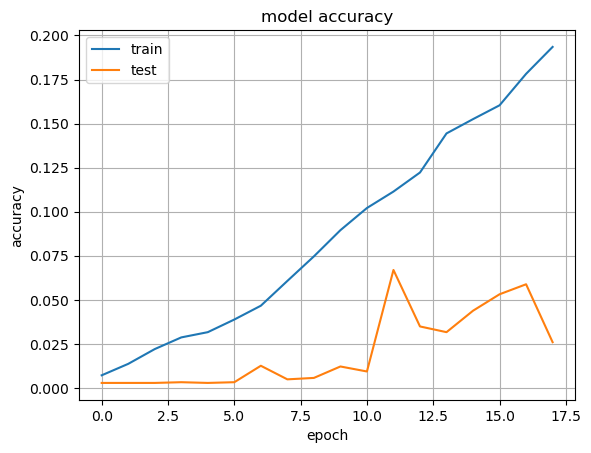

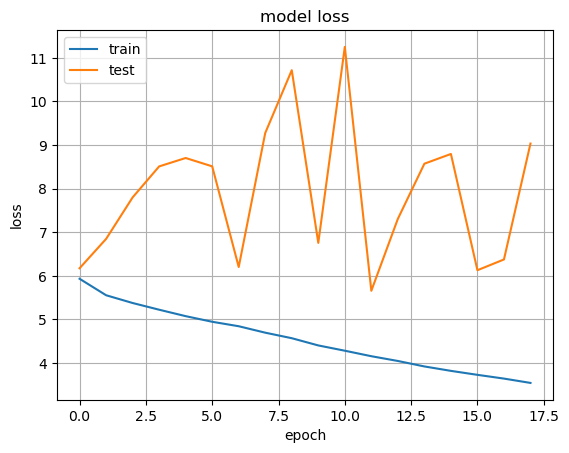

In [20]:
if testing == True:
    history = model.fit(
        x=aug.flow(tr_x, tr_Y, batch_size=batch_size),
        validation_data=(tst_x,tst_Y),
        epochs=30,
        shuffle = True,
        callbacks=callbacks)
else:
    history = model.fit(
        x=aug.flow(tr_x, tr_Y, batch_size=batch_size,shuffle=True),
        validation_data=(tst_x,tst_Y),
        epochs=200,
        callbacks=callbacks)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [21]:
gc.collect()

30567

# 6. Testing the model

In [22]:
del model
gc.collect()

21

## Loading saved model

In [23]:
from tensorflow.keras.models import load_model
model = load_model("my_best_model.h5")

## Importing testing data

In [24]:
test = pd.read_csv('../input/quickdraw-doodle-recognition/test_simplified.csv', index_col="key_id" ,nrows=100)
ids = test.index
imagebag = bag.from_sequence(test.drawing.values).map(drawStrokes)
test_simplified = np.array(imagebag.compute())
test_simplified = test_simplified.reshape(len(test_simplified), 32, 32, 3)

In [25]:
del imagebag
gc.collect()

21

## Make predictions

In [26]:
prediction = model.predict(test_simplified)
indexOfBigProbability = (-prediction).argsort()[:,:4]

4/4 [==============================] - 1s 121ms/step


In [27]:
gc.collect()

721

## Plotting the predictions

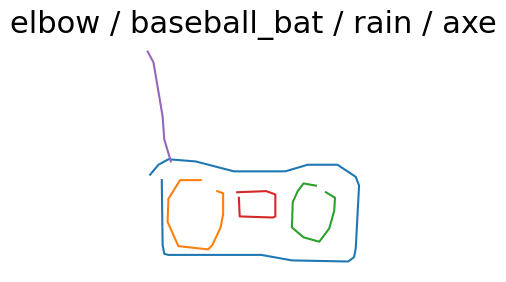

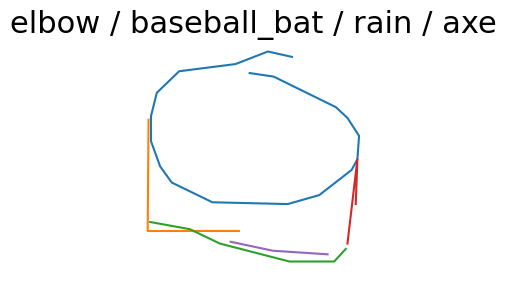

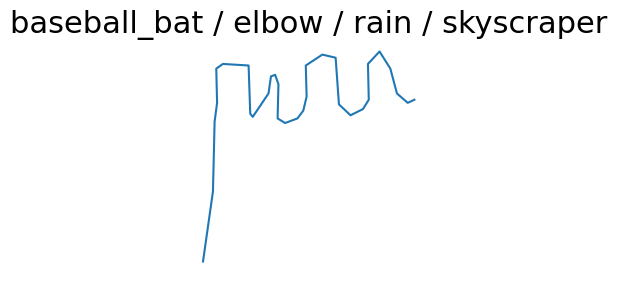

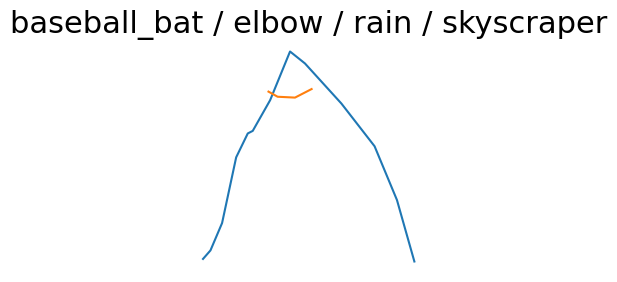

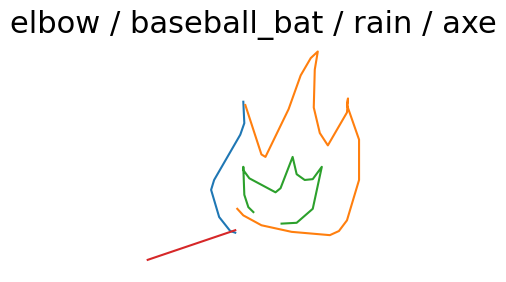

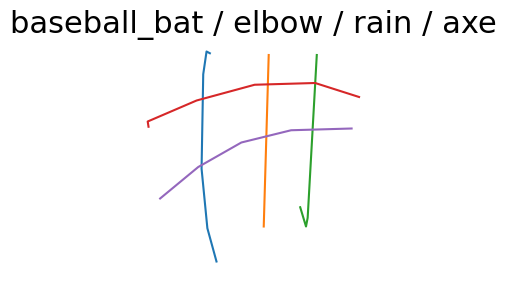

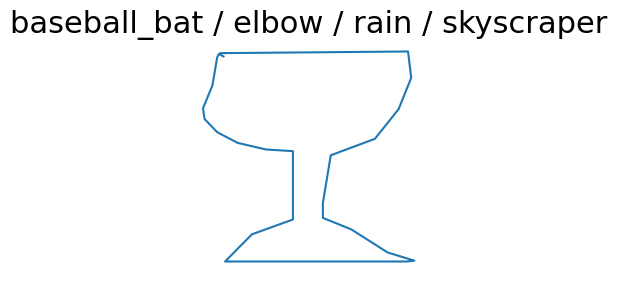

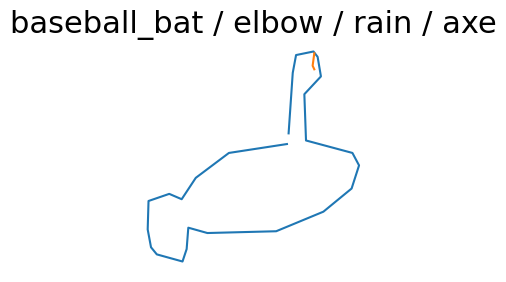

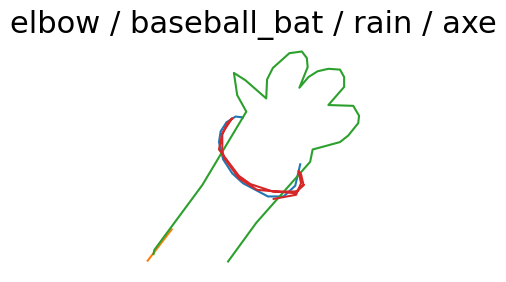

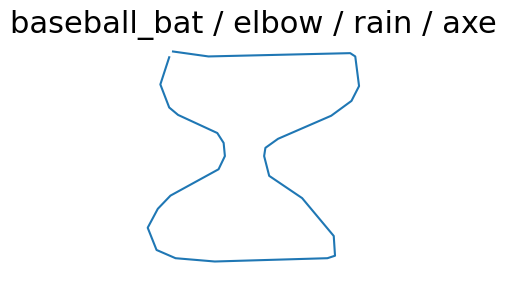

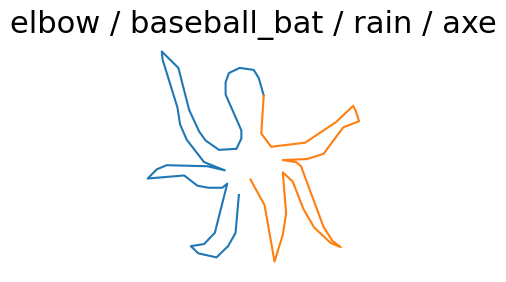

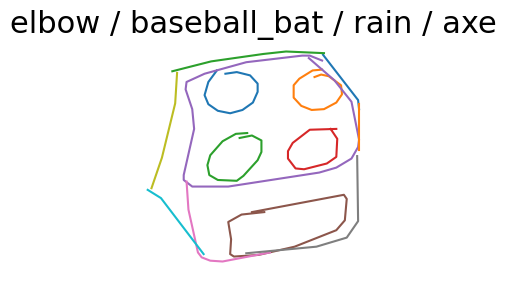

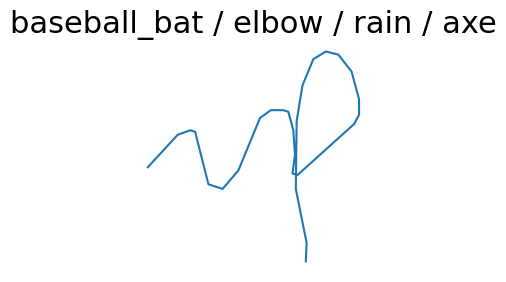

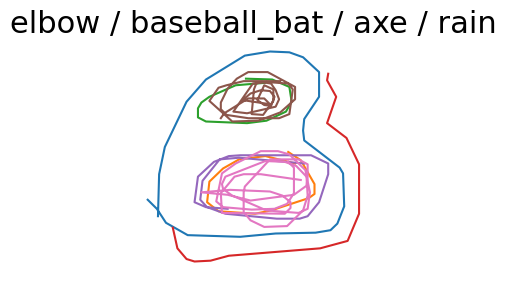

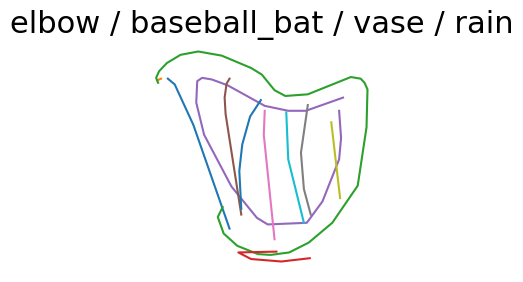

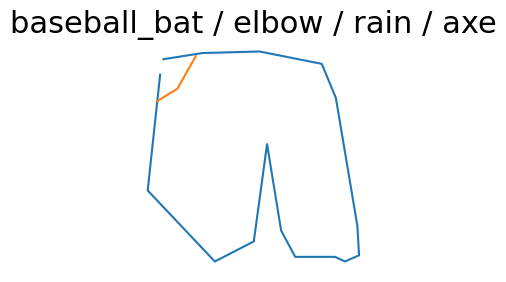

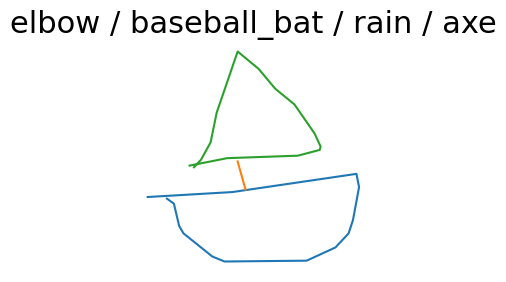

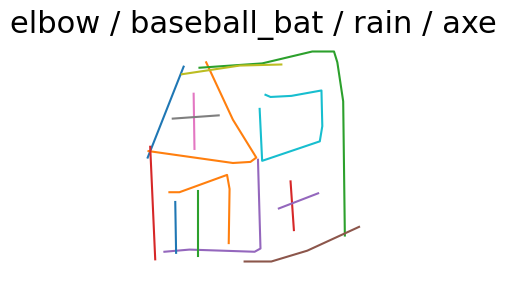

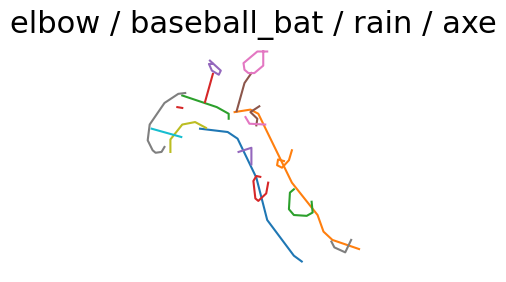

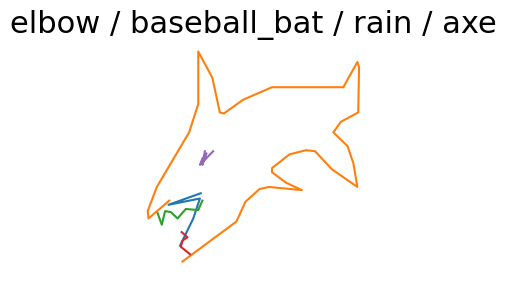

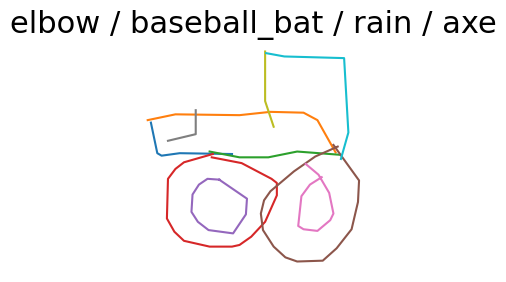

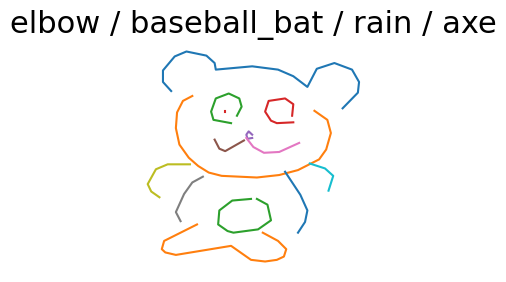

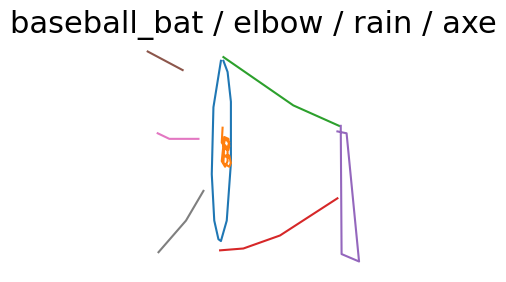

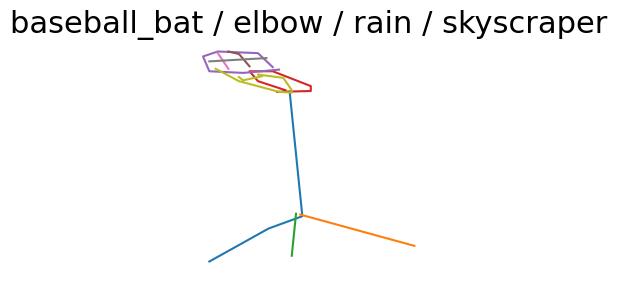

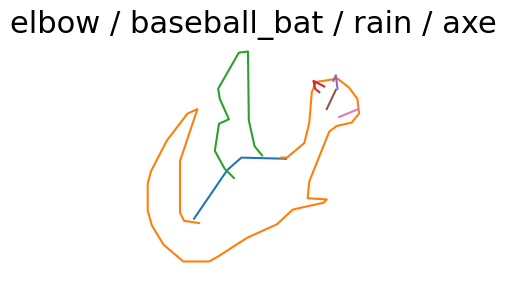

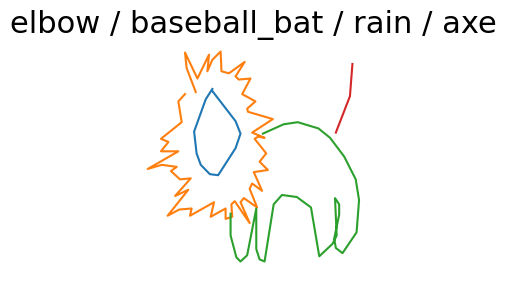

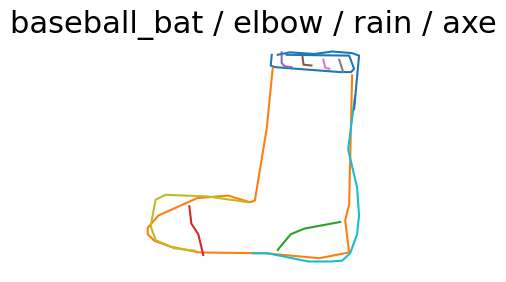

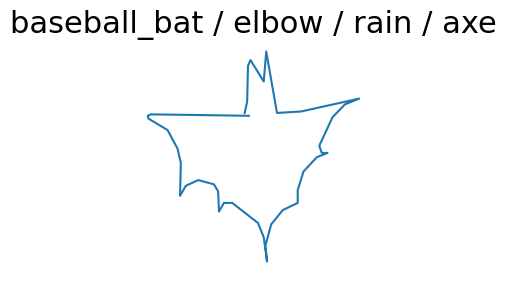

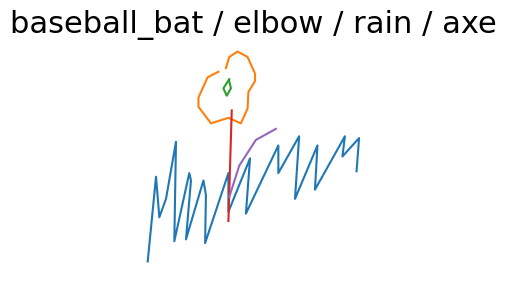

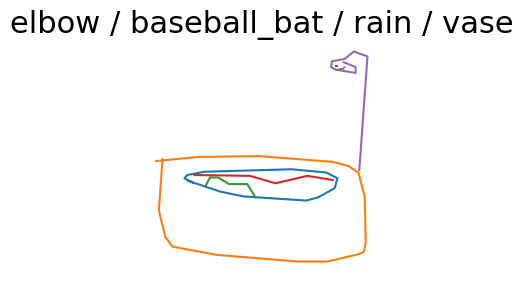

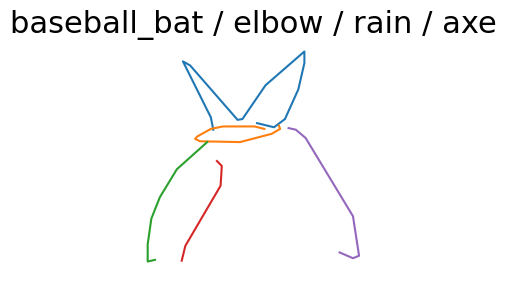

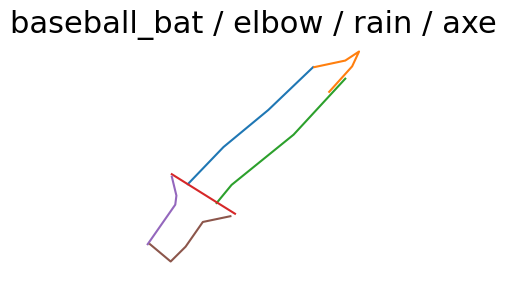

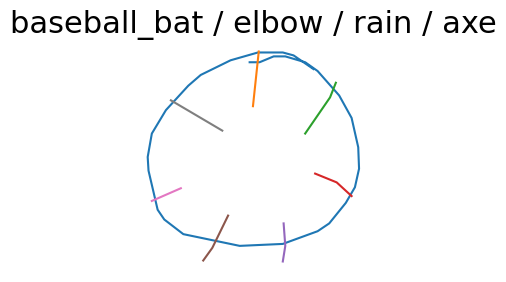

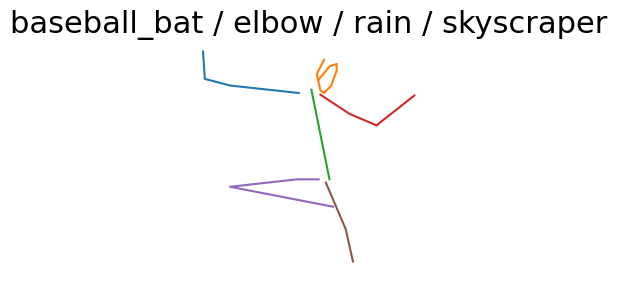

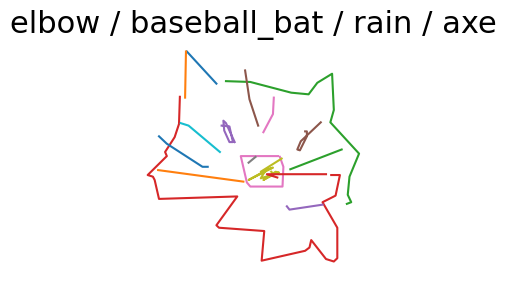

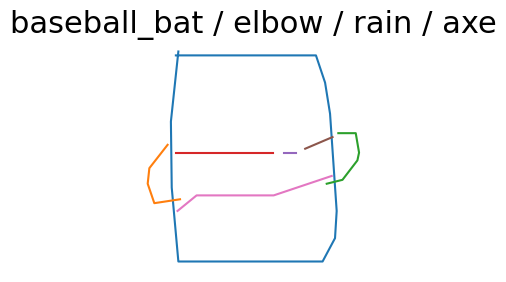

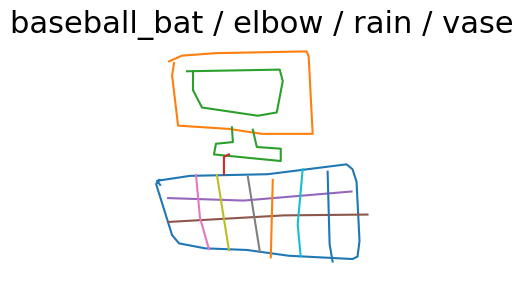

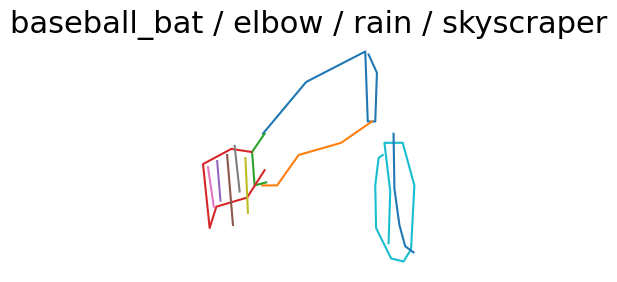

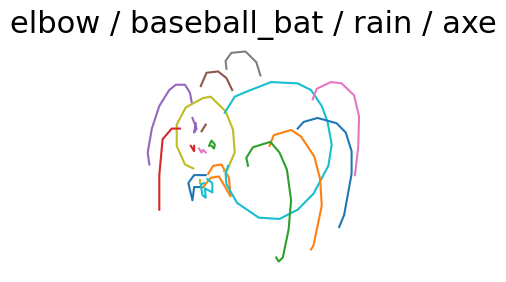

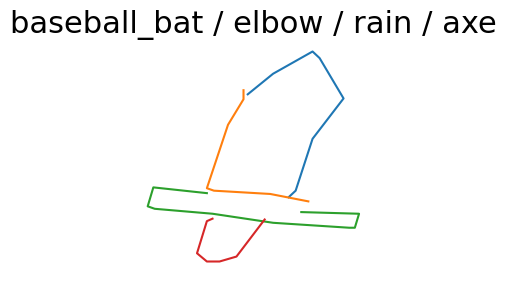

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import warnings
warnings.filterwarnings('ignore')

raw_images = [ast.literal_eval(lst) for lst in test.loc[test.iloc[:40].index, 'drawing'].values]

j=0

for index, raw_drawing in enumerate(raw_images):
    plt.figure(figsize=(3,3));
    for x,y in raw_drawing:
        title_obj=plt.title(Y.columns[indexOfBigProbability][j][0]
                  +" / "
                 +Y.columns[indexOfBigProbability][j][1]
                  +" / "
                 +Y.columns[indexOfBigProbability][j][2]
                  +" / "
                 +Y.columns[indexOfBigProbability][j][3], fontsize=22)
        plt.subplot(1, 1, 1);
        plt.plot(x,y);
        plt.axis('off');
    plt.gca().invert_yaxis();
    j+=1;